In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/bindsnet"

/content/drive/MyDrive/Colab Notebooks/bindsnet


In [ ]:
pip install git+https://github.com/BindsNET/bindsnet.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-v2lj1spa
  Running command git clone -q https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-v2lj1spa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import argparse
import os
from time import time as t

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm

from bindsnet.analysis.plotting import (
    plot_assignments,
    plot_input,
    plot_performance,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder, poisson
from bindsnet.evaluation import all_activity, assign_labels, proportion_weighting
from bindsnet.models import IncreasingInhibitionNetwork
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_assignments, get_square_weights

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--n_neurons", type=int, default=100)
parser.add_argument("--n_epochs", type=int, default=1)
parser.add_argument("--n_test", type=int, default=10000)
parser.add_argument("--n_train", type=int, default=60000)
parser.add_argument("--n_workers", type=int, default=-1)
parser.add_argument("--theta_plus", type=float, default=0.05)
parser.add_argument("--time", type=int, default=250)
parser.add_argument("--dt", type=int, default=1.0)
parser.add_argument("--intensity", type=float, default=64)
parser.add_argument("--progress_interval", type=int, default=10)
parser.add_argument("--update_interval", type=int, default=250)
parser.add_argument("--update_inhibation_weights", type=int, default=500)
parser.add_argument("--plot_interval", type=int, default=250)
parser.add_argument("--plot", dest="plot", action="store_true")
parser.add_argument("--gpu", dest="gpu", action="store_true")
parser.set_defaults(plot=True, gpu=True)

args = parser.parse_args(args=[])

seed = args.seed
n_neurons = args.n_neurons
n_epochs = args.n_epochs
n_test = args.n_test
n_train = args.n_train
n_workers = args.n_workers
theta_plus = args.theta_plus
time = args.time
dt = args.dt
intensity = args.intensity
progress_interval = args.progress_interval
plot_interval = args.plot_interval
update_interval = args.update_interval
plot = args.plot
gpu = args.gpu
update_inhibation_weights = args.update_inhibation_weights

In [ ]:
# Sets up Gpu use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)

# Determines number of workers to use
if n_workers == -1:
    n_workers = 0  # torch.cuda.is_available() * 4 * torch.cuda.device_count()

n_sqrt = int(np.ceil(np.sqrt(n_neurons)))
start_intensity = intensity

# Build network.
network = IncreasingInhibitionNetwork(
    n_input=784,
    n_neurons=n_neurons,
    start_inhib=10,
    max_inhib=-40.0,
    theta_plus=0.05,
    tc_theta_decay=1e7,
    inpt_shape=(1, 28, 28),
    nu=(1e-4, 1e-2),
)

network.to(device)

# Load MNIST data.
dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Record spikes during the simulation.
spike_record = torch.zeros((update_interval, int(time / dt), n_neurons), device=device)

# Neuron assignments and spike proportions.
n_classes = 10
assignments = -torch.ones(n_neurons, device=device)
proportions = torch.zeros((n_neurons, n_classes), device=device)
rates = torch.zeros((n_neurons, n_classes), device=device)

# Sequence of accuracy estimates.
accuracy = {"all": [], "proportion": []}

# Voltage recording for excitatory and inhibitory layers.
som_voltage_monitor = Monitor(
    network.layers["Y"], ["v"], time=int(time / dt), device=device
)
network.add_monitor(som_voltage_monitor, name="som_voltage")

Running on Device =  cuda


In [ ]:
# Set up monitors for spikes and voltages
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(
        network.layers[layer], state_vars=["s"], time=int(time / dt), device=device
    )
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(
        network.layers[layer], state_vars=["v"], time=int(time / dt), device=device
    )
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)

inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None
save_weights_fn = "plots/weights/weights.png"
save_performance_fn = "plots/performance/performance.png"
save_assaiments_fn = "plots/assaiments/assaiments.png"

directorys = ["plots", "plots/weights", "plots/performance", "plots/assaiments"]
for directory in directorys:
    if not os.path.exists(directory):
        os.makedirs(directory)

# diagonal weights for increassing the inhibitiosn
weights_mask = (1 - torch.diag(torch.ones(n_neurons))).to(device)



Begin training.

Progress: 0 / 1 (0.0006 seconds)


  0%|          | 0/60000 [00:00<?, ?it/s]

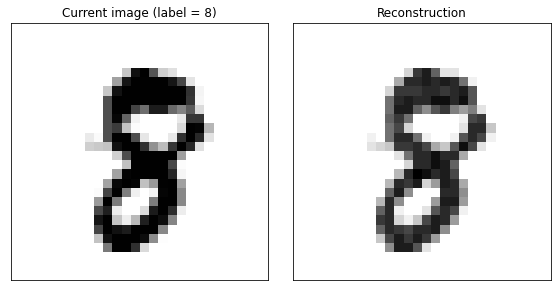

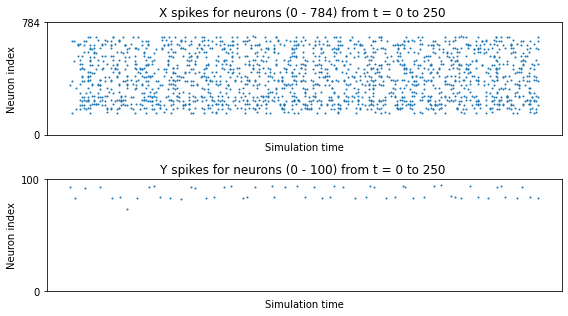

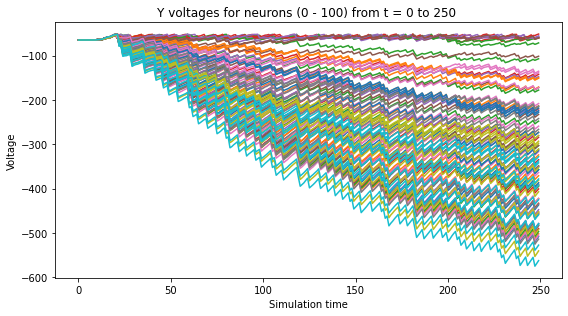

Train progress:   0%|          | 250/60000 [01:05<3:59:41,  4.15it/s]


All activity accuracy: 11.20 (last), 11.20 (average), 11.20 (best)
Proportion weighting accuracy: 11.20 (last), 11.20 (average), 11.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   1%|          | 500/60000 [02:06<3:55:29,  4.21it/s]


All activity accuracy: 14.40 (last), 12.80 (average), 14.40 (best)
Proportion weighting accuracy: 13.60 (last), 12.40 (average), 13.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   1%|▏         | 750/60000 [03:07<3:57:25,  4.16it/s]


All activity accuracy: 26.00 (last), 17.20 (average), 26.00 (best)
Proportion weighting accuracy: 24.80 (last), 16.53 (average), 24.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   2%|▏         | 1000/60000 [04:07<3:51:11,  4.25it/s]


All activity accuracy: 30.00 (last), 20.40 (average), 30.00 (best)
Proportion weighting accuracy: 31.20 (last), 20.20 (average), 31.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   2%|▏         | 1250/60000 [05:09<3:52:20,  4.21it/s]


All activity accuracy: 33.60 (last), 23.04 (average), 33.60 (best)
Proportion weighting accuracy: 31.20 (last), 22.40 (average), 31.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   2%|▎         | 1500/60000 [06:11<3:53:48,  4.17it/s]


All activity accuracy: 19.60 (last), 22.47 (average), 33.60 (best)
Proportion weighting accuracy: 20.40 (last), 22.07 (average), 31.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   3%|▎         | 1750/60000 [07:13<3:52:06,  4.18it/s]


All activity accuracy: 28.00 (last), 23.26 (average), 33.60 (best)
Proportion weighting accuracy: 27.20 (last), 22.80 (average), 31.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   3%|▎         | 2000/60000 [08:13<3:48:38,  4.23it/s]


All activity accuracy: 35.60 (last), 24.80 (average), 35.60 (best)
Proportion weighting accuracy: 34.80 (last), 24.30 (average), 34.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   4%|▍         | 2250/60000 [09:13<3:48:39,  4.21it/s]


All activity accuracy: 44.80 (last), 27.02 (average), 44.80 (best)
Proportion weighting accuracy: 43.60 (last), 26.44 (average), 43.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   4%|▍         | 2500/60000 [10:13<3:41:39,  4.32it/s]


All activity accuracy: 44.40 (last), 28.76 (average), 44.80 (best)
Proportion weighting accuracy: 44.80 (last), 28.28 (average), 44.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   5%|▍         | 2750/60000 [11:13<3:45:54,  4.22it/s]


All activity accuracy: 53.20 (last), 30.98 (average), 53.20 (best)
Proportion weighting accuracy: 52.80 (last), 30.51 (average), 52.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   5%|▌         | 3000/60000 [12:13<3:44:02,  4.24it/s]


All activity accuracy: 60.80 (last), 33.47 (average), 60.80 (best)
Proportion weighting accuracy: 60.00 (last), 32.97 (average), 60.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   5%|▌         | 3250/60000 [13:12<3:41:57,  4.26it/s]


All activity accuracy: 57.20 (last), 35.29 (average), 60.80 (best)
Proportion weighting accuracy: 56.40 (last), 34.77 (average), 60.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   6%|▌         | 3500/60000 [14:12<3:38:38,  4.31it/s]


All activity accuracy: 53.20 (last), 36.57 (average), 60.80 (best)
Proportion weighting accuracy: 51.60 (last), 35.97 (average), 60.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   6%|▋         | 3750/60000 [15:12<3:35:22,  4.35it/s]


All activity accuracy: 56.40 (last), 37.89 (average), 60.80 (best)
Proportion weighting accuracy: 56.40 (last), 37.33 (average), 60.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   7%|▋         | 4000/60000 [16:12<3:39:40,  4.25it/s]


All activity accuracy: 55.60 (last), 39.00 (average), 60.80 (best)
Proportion weighting accuracy: 56.80 (last), 38.55 (average), 60.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   7%|▋         | 4250/60000 [17:12<3:35:55,  4.30it/s]


All activity accuracy: 55.20 (last), 39.95 (average), 60.80 (best)
Proportion weighting accuracy: 54.80 (last), 39.51 (average), 60.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   8%|▊         | 4500/60000 [18:14<3:38:08,  4.24it/s]


All activity accuracy: 57.60 (last), 40.93 (average), 60.80 (best)
Proportion weighting accuracy: 54.80 (last), 40.36 (average), 60.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   8%|▊         | 4750/60000 [19:17<3:37:53,  4.23it/s]


All activity accuracy: 66.00 (last), 42.25 (average), 66.00 (best)
Proportion weighting accuracy: 63.20 (last), 41.56 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   8%|▊         | 5000/60000 [20:18<3:31:36,  4.33it/s]


All activity accuracy: 58.80 (last), 43.08 (average), 66.00 (best)
Proportion weighting accuracy: 58.40 (last), 42.40 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   9%|▉         | 5250/60000 [21:25<3:33:27,  4.27it/s]


All activity accuracy: 54.80 (last), 43.64 (average), 66.00 (best)
Proportion weighting accuracy: 56.00 (last), 43.05 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:   9%|▉         | 5500/60000 [22:31<3:55:23,  3.86it/s]


All activity accuracy: 56.40 (last), 44.22 (average), 66.00 (best)
Proportion weighting accuracy: 56.80 (last), 43.67 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  10%|▉         | 5750/60000 [23:38<3:34:34,  4.21it/s]


All activity accuracy: 60.40 (last), 44.92 (average), 66.00 (best)
Proportion weighting accuracy: 58.80 (last), 44.33 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  10%|█         | 6000/60000 [24:43<3:36:58,  4.15it/s]


All activity accuracy: 56.40 (last), 45.40 (average), 66.00 (best)
Proportion weighting accuracy: 56.40 (last), 44.83 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  10%|█         | 6250/60000 [25:47<3:24:45,  4.38it/s]


All activity accuracy: 60.00 (last), 45.98 (average), 66.00 (best)
Proportion weighting accuracy: 59.20 (last), 45.41 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  11%|█         | 6500/60000 [26:51<4:01:48,  3.69it/s]


All activity accuracy: 60.80 (last), 46.55 (average), 66.00 (best)
Proportion weighting accuracy: 60.80 (last), 46.00 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  11%|█▏        | 6750/60000 [27:57<3:24:47,  4.33it/s]


All activity accuracy: 60.00 (last), 47.05 (average), 66.00 (best)
Proportion weighting accuracy: 60.80 (last), 46.55 (average), 63.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  12%|█▏        | 7000/60000 [29:01<3:23:19,  4.34it/s]


All activity accuracy: 63.20 (last), 47.63 (average), 66.00 (best)
Proportion weighting accuracy: 64.40 (last), 47.19 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  12%|█▏        | 7250/60000 [30:04<4:43:41,  3.10it/s]


All activity accuracy: 62.80 (last), 48.15 (average), 66.00 (best)
Proportion weighting accuracy: 64.00 (last), 47.77 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  12%|█▎        | 7500/60000 [31:07<3:21:25,  4.34it/s]


All activity accuracy: 59.20 (last), 48.52 (average), 66.00 (best)
Proportion weighting accuracy: 58.80 (last), 48.13 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  13%|█▎        | 7750/60000 [32:09<3:18:24,  4.39it/s]


All activity accuracy: 61.20 (last), 48.93 (average), 66.00 (best)
Proportion weighting accuracy: 60.80 (last), 48.54 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  13%|█▎        | 8000/60000 [33:10<3:17:51,  4.38it/s]


All activity accuracy: 62.00 (last), 49.34 (average), 66.00 (best)
Proportion weighting accuracy: 62.80 (last), 48.99 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  14%|█▍        | 8250/60000 [34:17<5:54:56,  2.43it/s]


All activity accuracy: 58.40 (last), 49.61 (average), 66.00 (best)
Proportion weighting accuracy: 59.20 (last), 49.30 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  14%|█▍        | 8500/60000 [35:20<3:18:25,  4.33it/s]


All activity accuracy: 59.60 (last), 49.91 (average), 66.00 (best)
Proportion weighting accuracy: 59.60 (last), 49.60 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  15%|█▍        | 8750/60000 [36:21<3:17:57,  4.31it/s]


All activity accuracy: 58.00 (last), 50.14 (average), 66.00 (best)
Proportion weighting accuracy: 59.60 (last), 49.89 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  15%|█▌        | 9000/60000 [37:27<3:15:02,  4.36it/s]


All activity accuracy: 60.00 (last), 50.41 (average), 66.00 (best)
Proportion weighting accuracy: 62.80 (last), 50.24 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  15%|█▌        | 9250/60000 [38:30<3:14:32,  4.35it/s]


All activity accuracy: 60.40 (last), 50.68 (average), 66.00 (best)
Proportion weighting accuracy: 61.60 (last), 50.55 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  16%|█▌        | 9500/60000 [39:35<3:12:41,  4.37it/s]


All activity accuracy: 61.20 (last), 50.96 (average), 66.00 (best)
Proportion weighting accuracy: 62.80 (last), 50.87 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  16%|█▋        | 9750/60000 [40:38<3:20:53,  4.17it/s]


All activity accuracy: 56.80 (last), 51.11 (average), 66.00 (best)
Proportion weighting accuracy: 57.20 (last), 51.04 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  17%|█▋        | 10000/60000 [41:41<3:17:35,  4.22it/s]


All activity accuracy: 64.00 (last), 51.43 (average), 66.00 (best)
Proportion weighting accuracy: 64.40 (last), 51.37 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  17%|█▋        | 10250/60000 [42:48<3:36:18,  3.83it/s]


All activity accuracy: 60.40 (last), 51.65 (average), 66.00 (best)
Proportion weighting accuracy: 61.20 (last), 51.61 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  18%|█▊        | 10500/60000 [43:52<3:08:48,  4.37it/s]


All activity accuracy: 59.60 (last), 51.84 (average), 66.00 (best)
Proportion weighting accuracy: 60.00 (last), 51.81 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  18%|█▊        | 10750/60000 [44:57<3:07:29,  4.38it/s]


All activity accuracy: 60.80 (last), 52.05 (average), 66.00 (best)
Proportion weighting accuracy: 60.80 (last), 52.02 (average), 64.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  18%|█▊        | 11000/60000 [46:02<3:07:24,  4.36it/s]


All activity accuracy: 67.20 (last), 52.39 (average), 67.20 (best)
Proportion weighting accuracy: 67.20 (last), 52.36 (average), 67.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  19%|█▉        | 11250/60000 [47:09<3:07:53,  4.32it/s]


All activity accuracy: 67.20 (last), 52.72 (average), 67.20 (best)
Proportion weighting accuracy: 67.20 (last), 52.69 (average), 67.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  19%|█▉        | 11500/60000 [48:14<3:30:24,  3.84it/s]


All activity accuracy: 62.80 (last), 52.94 (average), 67.20 (best)
Proportion weighting accuracy: 62.80 (last), 52.91 (average), 67.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  20%|█▉        | 11750/60000 [49:16<3:12:29,  4.18it/s]


All activity accuracy: 68.40 (last), 53.27 (average), 68.40 (best)
Proportion weighting accuracy: 68.40 (last), 53.24 (average), 68.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  20%|██        | 12000/60000 [50:23<3:09:17,  4.23it/s]


All activity accuracy: 66.40 (last), 53.54 (average), 68.40 (best)
Proportion weighting accuracy: 66.40 (last), 53.52 (average), 68.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  20%|██        | 12250/60000 [51:30<3:05:22,  4.29it/s]


All activity accuracy: 59.20 (last), 53.66 (average), 68.40 (best)
Proportion weighting accuracy: 58.40 (last), 53.62 (average), 68.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  21%|██        | 12500/60000 [52:38<3:01:16,  4.37it/s]


All activity accuracy: 68.40 (last), 53.95 (average), 68.40 (best)
Proportion weighting accuracy: 68.40 (last), 53.91 (average), 68.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  21%|██▏       | 12750/60000 [53:44<5:22:30,  2.44it/s]


All activity accuracy: 68.00 (last), 54.23 (average), 68.40 (best)
Proportion weighting accuracy: 67.60 (last), 54.18 (average), 68.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  22%|██▏       | 13000/60000 [54:45<3:00:39,  4.34it/s]


All activity accuracy: 70.00 (last), 54.53 (average), 70.00 (best)
Proportion weighting accuracy: 70.00 (last), 54.48 (average), 70.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  22%|██▏       | 13250/60000 [55:45<2:59:27,  4.34it/s]


All activity accuracy: 70.00 (last), 54.82 (average), 70.00 (best)
Proportion weighting accuracy: 70.00 (last), 54.78 (average), 70.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  22%|██▎       | 13500/60000 [56:49<3:04:13,  4.21it/s]


All activity accuracy: 66.40 (last), 55.04 (average), 70.00 (best)
Proportion weighting accuracy: 66.40 (last), 54.99 (average), 70.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  23%|██▎       | 13750/60000 [57:51<3:02:40,  4.22it/s]


All activity accuracy: 71.20 (last), 55.33 (average), 71.20 (best)
Proportion weighting accuracy: 71.20 (last), 55.29 (average), 71.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  23%|██▎       | 14000/60000 [58:56<2:58:29,  4.30it/s]


All activity accuracy: 70.40 (last), 55.60 (average), 71.20 (best)
Proportion weighting accuracy: 70.40 (last), 55.56 (average), 71.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  24%|██▍       | 14250/60000 [1:00:01<2:54:08,  4.38it/s]


All activity accuracy: 63.20 (last), 55.73 (average), 71.20 (best)
Proportion weighting accuracy: 63.20 (last), 55.69 (average), 71.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  24%|██▍       | 14500/60000 [1:01:06<2:56:42,  4.29it/s]


All activity accuracy: 70.40 (last), 55.99 (average), 71.20 (best)
Proportion weighting accuracy: 70.40 (last), 55.94 (average), 71.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  25%|██▍       | 14750/60000 [1:02:09<2:52:45,  4.37it/s]


All activity accuracy: 76.00 (last), 56.33 (average), 76.00 (best)
Proportion weighting accuracy: 76.00 (last), 56.28 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  25%|██▌       | 15000/60000 [1:03:15<2:51:41,  4.37it/s]


All activity accuracy: 65.60 (last), 56.48 (average), 76.00 (best)
Proportion weighting accuracy: 65.60 (last), 56.44 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  25%|██▌       | 15250/60000 [1:04:21<2:49:52,  4.39it/s]


All activity accuracy: 68.40 (last), 56.68 (average), 76.00 (best)
Proportion weighting accuracy: 68.40 (last), 56.64 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  26%|██▌       | 15500/60000 [1:05:23<2:50:34,  4.35it/s]


All activity accuracy: 68.80 (last), 56.87 (average), 76.00 (best)
Proportion weighting accuracy: 68.80 (last), 56.83 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  26%|██▋       | 15750/60000 [1:06:27<2:50:00,  4.34it/s]


All activity accuracy: 70.00 (last), 57.08 (average), 76.00 (best)
Proportion weighting accuracy: 70.00 (last), 57.04 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  27%|██▋       | 16000/60000 [1:07:28<2:47:32,  4.38it/s]


All activity accuracy: 73.60 (last), 57.34 (average), 76.00 (best)
Proportion weighting accuracy: 73.60 (last), 57.30 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  27%|██▋       | 16250/60000 [1:08:29<2:46:52,  4.37it/s]


All activity accuracy: 68.40 (last), 57.51 (average), 76.00 (best)
Proportion weighting accuracy: 68.40 (last), 57.47 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  28%|██▊       | 16500/60000 [1:09:30<2:46:42,  4.35it/s]


All activity accuracy: 64.40 (last), 57.61 (average), 76.00 (best)
Proportion weighting accuracy: 64.40 (last), 57.58 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  28%|██▊       | 16750/60000 [1:10:33<2:51:55,  4.19it/s]


All activity accuracy: 76.00 (last), 57.89 (average), 76.00 (best)
Proportion weighting accuracy: 76.00 (last), 57.85 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  28%|██▊       | 17000/60000 [1:11:34<2:42:40,  4.41it/s]


All activity accuracy: 72.40 (last), 58.10 (average), 76.00 (best)
Proportion weighting accuracy: 72.80 (last), 58.07 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  29%|██▉       | 17250/60000 [1:12:33<2:52:02,  4.14it/s]


All activity accuracy: 71.60 (last), 58.30 (average), 76.00 (best)
Proportion weighting accuracy: 71.60 (last), 58.27 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  29%|██▉       | 17500/60000 [1:13:37<2:43:07,  4.34it/s]


All activity accuracy: 72.80 (last), 58.50 (average), 76.00 (best)
Proportion weighting accuracy: 72.80 (last), 58.47 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  30%|██▉       | 17750/60000 [1:14:40<2:41:27,  4.36it/s]


All activity accuracy: 72.80 (last), 58.70 (average), 76.00 (best)
Proportion weighting accuracy: 72.80 (last), 58.68 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  30%|███       | 18000/60000 [1:15:43<3:12:12,  3.64it/s]


All activity accuracy: 73.60 (last), 58.91 (average), 76.00 (best)
Proportion weighting accuracy: 73.60 (last), 58.88 (average), 76.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  30%|███       | 18250/60000 [1:16:45<2:40:56,  4.32it/s]


All activity accuracy: 76.40 (last), 59.15 (average), 76.40 (best)
Proportion weighting accuracy: 76.40 (last), 59.12 (average), 76.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  31%|███       | 18500/60000 [1:17:49<2:47:54,  4.12it/s]


All activity accuracy: 76.00 (last), 59.38 (average), 76.40 (best)
Proportion weighting accuracy: 76.00 (last), 59.35 (average), 76.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  31%|███▏      | 18750/60000 [1:18:50<2:37:43,  4.36it/s]


All activity accuracy: 78.40 (last), 59.63 (average), 78.40 (best)
Proportion weighting accuracy: 78.40 (last), 59.61 (average), 78.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  32%|███▏      | 19000/60000 [1:19:50<2:40:24,  4.26it/s]


All activity accuracy: 76.40 (last), 59.85 (average), 78.40 (best)
Proportion weighting accuracy: 76.40 (last), 59.83 (average), 78.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  32%|███▏      | 19250/60000 [1:20:52<2:36:56,  4.33it/s]


All activity accuracy: 76.00 (last), 60.06 (average), 78.40 (best)
Proportion weighting accuracy: 76.00 (last), 60.04 (average), 78.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  32%|███▎      | 19500/60000 [1:21:55<2:37:16,  4.29it/s]


All activity accuracy: 78.80 (last), 60.30 (average), 78.80 (best)
Proportion weighting accuracy: 78.80 (last), 60.28 (average), 78.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  33%|███▎      | 19750/60000 [1:23:03<2:33:15,  4.38it/s]


All activity accuracy: 68.40 (last), 60.41 (average), 78.80 (best)
Proportion weighting accuracy: 68.40 (last), 60.38 (average), 78.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  33%|███▎      | 20000/60000 [1:24:03<2:32:54,  4.36it/s]


All activity accuracy: 76.00 (last), 60.60 (average), 78.80 (best)
Proportion weighting accuracy: 76.00 (last), 60.58 (average), 78.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  34%|███▍      | 20250/60000 [1:25:05<2:34:08,  4.30it/s]


All activity accuracy: 81.60 (last), 60.86 (average), 81.60 (best)
Proportion weighting accuracy: 81.60 (last), 60.83 (average), 81.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  34%|███▍      | 20500/60000 [1:26:11<3:31:16,  3.12it/s]


All activity accuracy: 82.00 (last), 61.12 (average), 82.00 (best)
Proportion weighting accuracy: 82.00 (last), 61.09 (average), 82.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  35%|███▍      | 20750/60000 [1:27:14<2:29:28,  4.38it/s]


All activity accuracy: 81.20 (last), 61.36 (average), 82.00 (best)
Proportion weighting accuracy: 81.20 (last), 61.33 (average), 82.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  35%|███▌      | 21000/60000 [1:28:16<2:24:47,  4.49it/s]


All activity accuracy: 77.20 (last), 61.55 (average), 82.00 (best)
Proportion weighting accuracy: 77.20 (last), 61.52 (average), 82.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  35%|███▌      | 21250/60000 [1:29:17<2:27:48,  4.37it/s]


All activity accuracy: 81.60 (last), 61.78 (average), 82.00 (best)
Proportion weighting accuracy: 82.00 (last), 61.76 (average), 82.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  36%|███▌      | 21500/60000 [1:30:21<2:29:17,  4.30it/s]


All activity accuracy: 81.60 (last), 62.01 (average), 82.00 (best)
Proportion weighting accuracy: 81.60 (last), 62.00 (average), 82.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  36%|███▋      | 21750/60000 [1:31:21<2:30:16,  4.24it/s]


All activity accuracy: 82.80 (last), 62.25 (average), 82.80 (best)
Proportion weighting accuracy: 82.80 (last), 62.23 (average), 82.80 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  37%|███▋      | 22000/60000 [1:32:20<2:26:19,  4.33it/s]


All activity accuracy: 85.60 (last), 62.52 (average), 85.60 (best)
Proportion weighting accuracy: 85.60 (last), 62.50 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  37%|███▋      | 22250/60000 [1:33:23<3:24:39,  3.07it/s]


All activity accuracy: 77.60 (last), 62.69 (average), 85.60 (best)
Proportion weighting accuracy: 77.60 (last), 62.67 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  38%|███▊      | 22500/60000 [1:34:23<2:24:35,  4.32it/s]


All activity accuracy: 82.80 (last), 62.91 (average), 85.60 (best)
Proportion weighting accuracy: 82.80 (last), 62.89 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  38%|███▊      | 22750/60000 [1:35:26<2:23:39,  4.32it/s]


All activity accuracy: 79.60 (last), 63.09 (average), 85.60 (best)
Proportion weighting accuracy: 79.60 (last), 63.08 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  38%|███▊      | 23000/60000 [1:36:26<2:24:09,  4.28it/s]


All activity accuracy: 82.00 (last), 63.30 (average), 85.60 (best)
Proportion weighting accuracy: 82.00 (last), 63.28 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  39%|███▉      | 23250/60000 [1:37:26<2:20:42,  4.35it/s]


All activity accuracy: 78.80 (last), 63.47 (average), 85.60 (best)
Proportion weighting accuracy: 78.80 (last), 63.45 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  39%|███▉      | 23500/60000 [1:38:27<2:20:46,  4.32it/s]


All activity accuracy: 85.20 (last), 63.70 (average), 85.60 (best)
Proportion weighting accuracy: 85.20 (last), 63.68 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  40%|███▉      | 23750/60000 [1:39:30<2:20:57,  4.29it/s]


All activity accuracy: 85.20 (last), 63.92 (average), 85.60 (best)
Proportion weighting accuracy: 85.20 (last), 63.91 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  40%|████      | 24000/60000 [1:40:29<2:21:48,  4.23it/s]


All activity accuracy: 82.00 (last), 64.11 (average), 85.60 (best)
Proportion weighting accuracy: 82.00 (last), 64.10 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  40%|████      | 24250/60000 [1:41:31<2:18:15,  4.31it/s]


All activity accuracy: 79.20 (last), 64.27 (average), 85.60 (best)
Proportion weighting accuracy: 79.20 (last), 64.25 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  41%|████      | 24500/60000 [1:42:35<2:16:45,  4.33it/s]


All activity accuracy: 80.80 (last), 64.44 (average), 85.60 (best)
Proportion weighting accuracy: 80.80 (last), 64.42 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  41%|████▏     | 24750/60000 [1:43:38<2:17:09,  4.28it/s]


All activity accuracy: 80.80 (last), 64.60 (average), 85.60 (best)
Proportion weighting accuracy: 80.80 (last), 64.59 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  42%|████▏     | 25000/60000 [1:44:43<2:14:05,  4.35it/s]


All activity accuracy: 82.00 (last), 64.78 (average), 85.60 (best)
Proportion weighting accuracy: 82.00 (last), 64.76 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  42%|████▏     | 25250/60000 [1:45:45<2:13:35,  4.34it/s]


All activity accuracy: 79.20 (last), 64.92 (average), 85.60 (best)
Proportion weighting accuracy: 79.20 (last), 64.90 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  42%|████▎     | 25500/60000 [1:46:48<2:13:21,  4.31it/s]


All activity accuracy: 84.80 (last), 65.11 (average), 85.60 (best)
Proportion weighting accuracy: 84.80 (last), 65.10 (average), 85.60 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  43%|████▎     | 25750/60000 [1:47:49<2:12:37,  4.30it/s]


All activity accuracy: 86.40 (last), 65.32 (average), 86.40 (best)
Proportion weighting accuracy: 86.40 (last), 65.30 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  43%|████▎     | 26000/60000 [1:48:52<2:11:45,  4.30it/s]


All activity accuracy: 82.40 (last), 65.48 (average), 86.40 (best)
Proportion weighting accuracy: 82.40 (last), 65.47 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  44%|████▍     | 26250/60000 [1:49:55<2:11:41,  4.27it/s]


All activity accuracy: 80.00 (last), 65.62 (average), 86.40 (best)
Proportion weighting accuracy: 80.40 (last), 65.61 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  44%|████▍     | 26500/60000 [1:50:58<2:08:01,  4.36it/s]


All activity accuracy: 82.80 (last), 65.78 (average), 86.40 (best)
Proportion weighting accuracy: 82.80 (last), 65.77 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  45%|████▍     | 26750/60000 [1:52:04<2:08:10,  4.32it/s]


All activity accuracy: 81.20 (last), 65.93 (average), 86.40 (best)
Proportion weighting accuracy: 81.20 (last), 65.92 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  45%|████▌     | 27000/60000 [1:53:05<2:08:13,  4.29it/s]


All activity accuracy: 85.20 (last), 66.11 (average), 86.40 (best)
Proportion weighting accuracy: 85.20 (last), 66.10 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  45%|████▌     | 27250/60000 [1:54:08<2:06:45,  4.31it/s]


All activity accuracy: 79.20 (last), 66.23 (average), 86.40 (best)
Proportion weighting accuracy: 78.80 (last), 66.21 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  46%|████▌     | 27500/60000 [1:55:10<4:24:47,  2.05it/s]


All activity accuracy: 75.20 (last), 66.31 (average), 86.40 (best)
Proportion weighting accuracy: 74.80 (last), 66.29 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  46%|████▋     | 27750/60000 [1:56:13<2:04:10,  4.33it/s]


All activity accuracy: 84.80 (last), 66.48 (average), 86.40 (best)
Proportion weighting accuracy: 84.80 (last), 66.46 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  47%|████▋     | 28000/60000 [1:57:15<2:01:16,  4.40it/s]


All activity accuracy: 82.00 (last), 66.61 (average), 86.40 (best)
Proportion weighting accuracy: 82.00 (last), 66.60 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  47%|████▋     | 28250/60000 [1:58:18<2:50:14,  3.11it/s]


All activity accuracy: 83.20 (last), 66.76 (average), 86.40 (best)
Proportion weighting accuracy: 83.20 (last), 66.74 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  48%|████▊     | 28500/60000 [1:59:20<2:01:13,  4.33it/s]


All activity accuracy: 86.00 (last), 66.93 (average), 86.40 (best)
Proportion weighting accuracy: 85.60 (last), 66.91 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  48%|████▊     | 28750/60000 [2:00:23<1:59:12,  4.37it/s]


All activity accuracy: 82.80 (last), 67.07 (average), 86.40 (best)
Proportion weighting accuracy: 82.80 (last), 67.05 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  48%|████▊     | 29000/60000 [2:01:26<2:00:26,  4.29it/s]


All activity accuracy: 82.00 (last), 67.20 (average), 86.40 (best)
Proportion weighting accuracy: 82.00 (last), 67.18 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  49%|████▉     | 29250/60000 [2:02:27<1:59:00,  4.31it/s]


All activity accuracy: 80.00 (last), 67.31 (average), 86.40 (best)
Proportion weighting accuracy: 80.00 (last), 67.29 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  49%|████▉     | 29500/60000 [2:03:33<1:56:07,  4.38it/s]


All activity accuracy: 76.80 (last), 67.39 (average), 86.40 (best)
Proportion weighting accuracy: 76.80 (last), 67.37 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  50%|████▉     | 29750/60000 [2:04:33<1:56:32,  4.33it/s]


All activity accuracy: 76.80 (last), 67.47 (average), 86.40 (best)
Proportion weighting accuracy: 76.80 (last), 67.45 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  50%|█████     | 30000/60000 [2:05:39<1:58:32,  4.22it/s]


All activity accuracy: 79.20 (last), 67.56 (average), 86.40 (best)
Proportion weighting accuracy: 79.20 (last), 67.54 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  50%|█████     | 30250/60000 [2:06:43<2:09:49,  3.82it/s]


All activity accuracy: 81.60 (last), 67.68 (average), 86.40 (best)
Proportion weighting accuracy: 81.60 (last), 67.66 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  51%|█████     | 30500/60000 [2:07:45<2:15:35,  3.63it/s]


All activity accuracy: 81.20 (last), 67.79 (average), 86.40 (best)
Proportion weighting accuracy: 81.60 (last), 67.77 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  51%|█████▏    | 30750/60000 [2:08:48<1:51:22,  4.38it/s]


All activity accuracy: 82.00 (last), 67.91 (average), 86.40 (best)
Proportion weighting accuracy: 82.00 (last), 67.89 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  52%|█████▏    | 31000/60000 [2:09:52<1:52:15,  4.31it/s]


All activity accuracy: 82.00 (last), 68.02 (average), 86.40 (best)
Proportion weighting accuracy: 82.00 (last), 68.00 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  52%|█████▏    | 31250/60000 [2:10:59<1:51:26,  4.30it/s]


All activity accuracy: 85.20 (last), 68.16 (average), 86.40 (best)
Proportion weighting accuracy: 85.20 (last), 68.14 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  52%|█████▎    | 31500/60000 [2:12:01<1:50:06,  4.31it/s]


All activity accuracy: 84.40 (last), 68.29 (average), 86.40 (best)
Proportion weighting accuracy: 84.40 (last), 68.27 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  53%|█████▎    | 31750/60000 [2:13:03<1:47:42,  4.37it/s]


All activity accuracy: 84.00 (last), 68.41 (average), 86.40 (best)
Proportion weighting accuracy: 84.00 (last), 68.39 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  53%|█████▎    | 32000/60000 [2:14:04<1:48:04,  4.32it/s]


All activity accuracy: 84.40 (last), 68.53 (average), 86.40 (best)
Proportion weighting accuracy: 84.40 (last), 68.52 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  54%|█████▍    | 32250/60000 [2:15:05<2:03:58,  3.73it/s]


All activity accuracy: 82.00 (last), 68.64 (average), 86.40 (best)
Proportion weighting accuracy: 82.00 (last), 68.62 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  54%|█████▍    | 32500/60000 [2:16:08<1:44:03,  4.40it/s]


All activity accuracy: 84.80 (last), 68.76 (average), 86.40 (best)
Proportion weighting accuracy: 84.80 (last), 68.75 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  55%|█████▍    | 32750/60000 [2:17:12<2:25:35,  3.12it/s]


All activity accuracy: 82.40 (last), 68.87 (average), 86.40 (best)
Proportion weighting accuracy: 82.40 (last), 68.85 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  55%|█████▌    | 33000/60000 [2:18:16<2:01:36,  3.70it/s]


All activity accuracy: 82.40 (last), 68.97 (average), 86.40 (best)
Proportion weighting accuracy: 82.40 (last), 68.95 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  55%|█████▌    | 33250/60000 [2:19:18<1:42:17,  4.36it/s]


All activity accuracy: 83.60 (last), 69.08 (average), 86.40 (best)
Proportion weighting accuracy: 83.60 (last), 69.06 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  56%|█████▌    | 33500/60000 [2:20:19<2:08:57,  3.42it/s]


All activity accuracy: 84.00 (last), 69.19 (average), 86.40 (best)
Proportion weighting accuracy: 84.00 (last), 69.18 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  56%|█████▋    | 33750/60000 [2:21:25<3:02:09,  2.40it/s]


All activity accuracy: 81.20 (last), 69.28 (average), 86.40 (best)
Proportion weighting accuracy: 81.20 (last), 69.27 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  57%|█████▋    | 34000/60000 [2:22:25<1:40:03,  4.33it/s]


All activity accuracy: 82.00 (last), 69.37 (average), 86.40 (best)
Proportion weighting accuracy: 82.00 (last), 69.36 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  57%|█████▋    | 34250/60000 [2:23:27<2:55:05,  2.45it/s]


All activity accuracy: 78.80 (last), 69.44 (average), 86.40 (best)
Proportion weighting accuracy: 78.80 (last), 69.43 (average), 86.40 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  57%|█████▊    | 34500/60000 [2:24:29<1:37:12,  4.37it/s]


All activity accuracy: 87.20 (last), 69.57 (average), 87.20 (best)
Proportion weighting accuracy: 87.20 (last), 69.56 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  58%|█████▊    | 34750/60000 [2:25:30<1:36:43,  4.35it/s]


All activity accuracy: 82.00 (last), 69.66 (average), 87.20 (best)
Proportion weighting accuracy: 82.00 (last), 69.65 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  58%|█████▊    | 35000/60000 [2:26:33<1:35:16,  4.37it/s]


All activity accuracy: 82.40 (last), 69.75 (average), 87.20 (best)
Proportion weighting accuracy: 82.40 (last), 69.74 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  59%|█████▉    | 35250/60000 [2:27:36<1:34:59,  4.34it/s]


All activity accuracy: 86.40 (last), 69.87 (average), 87.20 (best)
Proportion weighting accuracy: 86.40 (last), 69.86 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  59%|█████▉    | 35500/60000 [2:28:38<1:51:18,  3.67it/s]


All activity accuracy: 82.40 (last), 69.96 (average), 87.20 (best)
Proportion weighting accuracy: 82.40 (last), 69.94 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  60%|█████▉    | 35750/60000 [2:29:40<1:56:39,  3.46it/s]


All activity accuracy: 84.40 (last), 70.06 (average), 87.20 (best)
Proportion weighting accuracy: 84.40 (last), 70.04 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  60%|██████    | 36000/60000 [2:30:46<1:35:31,  4.19it/s]


All activity accuracy: 86.40 (last), 70.17 (average), 87.20 (best)
Proportion weighting accuracy: 86.40 (last), 70.16 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  60%|██████    | 36250/60000 [2:31:46<1:33:47,  4.22it/s]


All activity accuracy: 83.60 (last), 70.26 (average), 87.20 (best)
Proportion weighting accuracy: 83.60 (last), 70.25 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  61%|██████    | 36500/60000 [2:32:52<1:40:17,  3.90it/s]


All activity accuracy: 79.60 (last), 70.33 (average), 87.20 (best)
Proportion weighting accuracy: 79.60 (last), 70.32 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  61%|██████▏   | 36750/60000 [2:33:55<1:29:49,  4.31it/s]


All activity accuracy: 80.80 (last), 70.40 (average), 87.20 (best)
Proportion weighting accuracy: 80.80 (last), 70.39 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  62%|██████▏   | 37000/60000 [2:34:58<1:26:50,  4.41it/s]


All activity accuracy: 78.80 (last), 70.46 (average), 87.20 (best)
Proportion weighting accuracy: 78.80 (last), 70.44 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  62%|██████▏   | 37250/60000 [2:36:01<1:26:38,  4.38it/s]


All activity accuracy: 82.00 (last), 70.53 (average), 87.20 (best)
Proportion weighting accuracy: 82.00 (last), 70.52 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  62%|██████▎   | 37500/60000 [2:37:04<1:28:48,  4.22it/s]


All activity accuracy: 85.60 (last), 70.63 (average), 87.20 (best)
Proportion weighting accuracy: 85.60 (last), 70.62 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  63%|██████▎   | 37750/60000 [2:38:09<2:11:00,  2.83it/s]


All activity accuracy: 80.80 (last), 70.70 (average), 87.20 (best)
Proportion weighting accuracy: 80.80 (last), 70.69 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  63%|██████▎   | 38000/60000 [2:39:10<1:24:00,  4.36it/s]


All activity accuracy: 84.80 (last), 70.79 (average), 87.20 (best)
Proportion weighting accuracy: 84.80 (last), 70.78 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  64%|██████▍   | 38250/60000 [2:40:12<1:26:59,  4.17it/s]


All activity accuracy: 81.20 (last), 70.86 (average), 87.20 (best)
Proportion weighting accuracy: 81.20 (last), 70.85 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  64%|██████▍   | 38500/60000 [2:41:15<1:23:20,  4.30it/s]


All activity accuracy: 83.60 (last), 70.95 (average), 87.20 (best)
Proportion weighting accuracy: 83.60 (last), 70.93 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  65%|██████▍   | 38750/60000 [2:42:19<1:21:01,  4.37it/s]


All activity accuracy: 81.20 (last), 71.01 (average), 87.20 (best)
Proportion weighting accuracy: 81.20 (last), 71.00 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  65%|██████▌   | 39000/60000 [2:43:25<2:23:52,  2.43it/s]


All activity accuracy: 85.20 (last), 71.10 (average), 87.20 (best)
Proportion weighting accuracy: 85.20 (last), 71.09 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  65%|██████▌   | 39250/60000 [2:44:26<1:26:45,  3.99it/s]


All activity accuracy: 84.40 (last), 71.19 (average), 87.20 (best)
Proportion weighting accuracy: 84.80 (last), 71.18 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  66%|██████▌   | 39500/60000 [2:45:31<1:19:05,  4.32it/s]


All activity accuracy: 82.40 (last), 71.26 (average), 87.20 (best)
Proportion weighting accuracy: 82.40 (last), 71.25 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  66%|██████▋   | 39750/60000 [2:46:33<1:17:53,  4.33it/s]


All activity accuracy: 85.20 (last), 71.35 (average), 87.20 (best)
Proportion weighting accuracy: 85.20 (last), 71.34 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  67%|██████▋   | 40000/60000 [2:47:34<1:18:04,  4.27it/s]


All activity accuracy: 82.00 (last), 71.41 (average), 87.20 (best)
Proportion weighting accuracy: 82.40 (last), 71.41 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  67%|██████▋   | 40250/60000 [2:48:34<1:15:03,  4.39it/s]


All activity accuracy: 83.60 (last), 71.49 (average), 87.20 (best)
Proportion weighting accuracy: 83.60 (last), 71.48 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  68%|██████▊   | 40500/60000 [2:49:36<1:15:37,  4.30it/s]


All activity accuracy: 82.00 (last), 71.55 (average), 87.20 (best)
Proportion weighting accuracy: 82.00 (last), 71.55 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  68%|██████▊   | 40750/60000 [2:50:37<1:14:32,  4.30it/s]


All activity accuracy: 83.60 (last), 71.63 (average), 87.20 (best)
Proportion weighting accuracy: 83.60 (last), 71.62 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  68%|██████▊   | 41000/60000 [2:51:39<1:12:50,  4.35it/s]


All activity accuracy: 84.80 (last), 71.71 (average), 87.20 (best)
Proportion weighting accuracy: 84.80 (last), 71.70 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  69%|██████▉   | 41250/60000 [2:52:42<1:11:58,  4.34it/s]


All activity accuracy: 82.00 (last), 71.77 (average), 87.20 (best)
Proportion weighting accuracy: 82.00 (last), 71.76 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  69%|██████▉   | 41500/60000 [2:53:45<1:10:34,  4.37it/s]


All activity accuracy: 86.00 (last), 71.86 (average), 87.20 (best)
Proportion weighting accuracy: 86.00 (last), 71.85 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  70%|██████▉   | 41750/60000 [2:54:50<1:14:23,  4.09it/s]


All activity accuracy: 82.00 (last), 71.92 (average), 87.20 (best)
Proportion weighting accuracy: 82.00 (last), 71.91 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  70%|███████   | 42000/60000 [2:55:54<1:21:55,  3.66it/s]


All activity accuracy: 82.80 (last), 71.98 (average), 87.20 (best)
Proportion weighting accuracy: 82.80 (last), 71.97 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  70%|███████   | 42250/60000 [2:56:57<1:44:56,  2.82it/s]


All activity accuracy: 84.80 (last), 72.06 (average), 87.20 (best)
Proportion weighting accuracy: 84.80 (last), 72.05 (average), 87.20 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  71%|███████   | 42500/60000 [2:57:59<1:10:06,  4.16it/s]


All activity accuracy: 92.00 (last), 72.17 (average), 92.00 (best)
Proportion weighting accuracy: 92.00 (last), 72.17 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  71%|███████▏  | 42750/60000 [2:59:02<1:06:33,  4.32it/s]


All activity accuracy: 82.00 (last), 72.23 (average), 92.00 (best)
Proportion weighting accuracy: 82.80 (last), 72.23 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  72%|███████▏  | 43000/60000 [3:00:06<1:11:39,  3.95it/s]


All activity accuracy: 82.00 (last), 72.29 (average), 92.00 (best)
Proportion weighting accuracy: 82.00 (last), 72.29 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  72%|███████▏  | 43250/60000 [3:01:07<1:05:13,  4.28it/s]


All activity accuracy: 78.80 (last), 72.33 (average), 92.00 (best)
Proportion weighting accuracy: 78.80 (last), 72.32 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  72%|███████▎  | 43500/60000 [3:02:11<1:04:45,  4.25it/s]


All activity accuracy: 84.80 (last), 72.40 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 72.40 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  73%|███████▎  | 43750/60000 [3:03:13<1:02:08,  4.36it/s]


All activity accuracy: 84.80 (last), 72.47 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 72.47 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  73%|███████▎  | 44000/60000 [3:04:15<1:01:15,  4.35it/s]


All activity accuracy: 84.40 (last), 72.54 (average), 92.00 (best)
Proportion weighting accuracy: 84.40 (last), 72.53 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  74%|███████▍  | 44250/60000 [3:05:15<1:00:55,  4.31it/s]


All activity accuracy: 83.60 (last), 72.60 (average), 92.00 (best)
Proportion weighting accuracy: 83.60 (last), 72.60 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  74%|███████▍  | 44500/60000 [3:06:17<59:52,  4.31it/s]


All activity accuracy: 84.80 (last), 72.67 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 72.67 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  75%|███████▍  | 44750/60000 [3:07:21<59:56,  4.24it/s]


All activity accuracy: 78.80 (last), 72.70 (average), 92.00 (best)
Proportion weighting accuracy: 79.20 (last), 72.70 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  75%|███████▌  | 45000/60000 [3:08:21<57:27,  4.35it/s]


All activity accuracy: 88.40 (last), 72.79 (average), 92.00 (best)
Proportion weighting accuracy: 88.40 (last), 72.79 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  75%|███████▌  | 45250/60000 [3:09:23<57:49,  4.25it/s]


All activity accuracy: 84.80 (last), 72.86 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 72.86 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  76%|███████▌  | 45500/60000 [3:10:27<58:12,  4.15it/s]


All activity accuracy: 83.60 (last), 72.91 (average), 92.00 (best)
Proportion weighting accuracy: 83.60 (last), 72.91 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  76%|███████▋  | 45750/60000 [3:11:35<58:12,  4.08it/s]


All activity accuracy: 83.20 (last), 72.97 (average), 92.00 (best)
Proportion weighting accuracy: 83.20 (last), 72.97 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  77%|███████▋  | 46000/60000 [3:12:37<55:00,  4.24it/s]


All activity accuracy: 81.20 (last), 73.02 (average), 92.00 (best)
Proportion weighting accuracy: 81.20 (last), 73.02 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  77%|███████▋  | 46250/60000 [3:13:45<53:18,  4.30it/s]


All activity accuracy: 80.00 (last), 73.05 (average), 92.00 (best)
Proportion weighting accuracy: 80.00 (last), 73.05 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  78%|███████▊  | 46500/60000 [3:14:50<1:20:54,  2.78it/s]


All activity accuracy: 83.20 (last), 73.11 (average), 92.00 (best)
Proportion weighting accuracy: 83.20 (last), 73.11 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  78%|███████▊  | 46750/60000 [3:15:56<1:17:47,  2.84it/s]


All activity accuracy: 78.80 (last), 73.14 (average), 92.00 (best)
Proportion weighting accuracy: 78.80 (last), 73.14 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  78%|███████▊  | 47000/60000 [3:16:59<49:27,  4.38it/s]


All activity accuracy: 82.80 (last), 73.19 (average), 92.00 (best)
Proportion weighting accuracy: 82.80 (last), 73.19 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  79%|███████▉  | 47250/60000 [3:18:02<49:24,  4.30it/s]


All activity accuracy: 83.60 (last), 73.24 (average), 92.00 (best)
Proportion weighting accuracy: 83.60 (last), 73.24 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  79%|███████▉  | 47500/60000 [3:19:04<48:32,  4.29it/s]


All activity accuracy: 86.40 (last), 73.31 (average), 92.00 (best)
Proportion weighting accuracy: 86.40 (last), 73.31 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  80%|███████▉  | 47750/60000 [3:20:08<46:37,  4.38it/s]


All activity accuracy: 84.40 (last), 73.37 (average), 92.00 (best)
Proportion weighting accuracy: 84.40 (last), 73.37 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  80%|████████  | 48000/60000 [3:21:10<47:07,  4.24it/s]


All activity accuracy: 83.20 (last), 73.42 (average), 92.00 (best)
Proportion weighting accuracy: 83.20 (last), 73.42 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  80%|████████  | 48250/60000 [3:22:13<45:57,  4.26it/s]


All activity accuracy: 84.40 (last), 73.48 (average), 92.00 (best)
Proportion weighting accuracy: 84.40 (last), 73.48 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  81%|████████  | 48500/60000 [3:23:19<1:08:19,  2.81it/s]


All activity accuracy: 84.00 (last), 73.53 (average), 92.00 (best)
Proportion weighting accuracy: 84.00 (last), 73.53 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  81%|████████▏ | 48750/60000 [3:24:22<45:50,  4.09it/s]


All activity accuracy: 86.80 (last), 73.60 (average), 92.00 (best)
Proportion weighting accuracy: 86.80 (last), 73.60 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  82%|████████▏ | 49000/60000 [3:25:24<42:48,  4.28it/s]


All activity accuracy: 80.80 (last), 73.64 (average), 92.00 (best)
Proportion weighting accuracy: 80.80 (last), 73.64 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  82%|████████▏ | 49250/60000 [3:26:26<41:22,  4.33it/s]


All activity accuracy: 86.00 (last), 73.70 (average), 92.00 (best)
Proportion weighting accuracy: 86.00 (last), 73.70 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  82%|████████▎ | 49500/60000 [3:27:30<1:24:54,  2.06it/s]


All activity accuracy: 86.80 (last), 73.77 (average), 92.00 (best)
Proportion weighting accuracy: 86.80 (last), 73.77 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  83%|████████▎ | 49750/60000 [3:28:37<41:36,  4.11it/s]


All activity accuracy: 82.00 (last), 73.81 (average), 92.00 (best)
Proportion weighting accuracy: 82.00 (last), 73.81 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  83%|████████▎ | 50000/60000 [3:29:39<38:27,  4.33it/s]


All activity accuracy: 80.80 (last), 73.84 (average), 92.00 (best)
Proportion weighting accuracy: 80.80 (last), 73.84 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  84%|████████▍ | 50250/60000 [3:30:41<38:10,  4.26it/s]


All activity accuracy: 87.20 (last), 73.91 (average), 92.00 (best)
Proportion weighting accuracy: 87.20 (last), 73.91 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  84%|████████▍ | 50500/60000 [3:31:43<36:32,  4.33it/s]


All activity accuracy: 85.60 (last), 73.97 (average), 92.00 (best)
Proportion weighting accuracy: 85.60 (last), 73.97 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  85%|████████▍ | 50750/60000 [3:32:46<36:04,  4.27it/s]


All activity accuracy: 84.40 (last), 74.02 (average), 92.00 (best)
Proportion weighting accuracy: 84.40 (last), 74.02 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  85%|████████▌ | 51000/60000 [3:33:48<34:26,  4.36it/s]


All activity accuracy: 83.20 (last), 74.06 (average), 92.00 (best)
Proportion weighting accuracy: 83.20 (last), 74.06 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  85%|████████▌ | 51250/60000 [3:34:50<34:17,  4.25it/s]


All activity accuracy: 86.80 (last), 74.13 (average), 92.00 (best)
Proportion weighting accuracy: 86.80 (last), 74.13 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  86%|████████▌ | 51500/60000 [3:35:57<33:08,  4.28it/s]


All activity accuracy: 82.40 (last), 74.17 (average), 92.00 (best)
Proportion weighting accuracy: 82.40 (last), 74.17 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  86%|████████▋ | 51750/60000 [3:37:02<32:32,  4.23it/s]


All activity accuracy: 82.40 (last), 74.21 (average), 92.00 (best)
Proportion weighting accuracy: 82.40 (last), 74.21 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  87%|████████▋ | 52000/60000 [3:38:05<31:38,  4.21it/s]


All activity accuracy: 83.20 (last), 74.25 (average), 92.00 (best)
Proportion weighting accuracy: 83.20 (last), 74.25 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  87%|████████▋ | 52250/60000 [3:39:07<46:47,  2.76it/s]


All activity accuracy: 87.20 (last), 74.31 (average), 92.00 (best)
Proportion weighting accuracy: 87.20 (last), 74.31 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  88%|████████▊ | 52500/60000 [3:40:10<28:46,  4.34it/s]


All activity accuracy: 84.00 (last), 74.36 (average), 92.00 (best)
Proportion weighting accuracy: 84.00 (last), 74.36 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  88%|████████▊ | 52750/60000 [3:41:18<28:02,  4.31it/s]


All activity accuracy: 86.00 (last), 74.41 (average), 92.00 (best)
Proportion weighting accuracy: 86.00 (last), 74.41 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  88%|████████▊ | 53000/60000 [3:42:19<27:03,  4.31it/s]


All activity accuracy: 84.80 (last), 74.46 (average), 92.00 (best)
Proportion weighting accuracy: 85.20 (last), 74.46 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  89%|████████▉ | 53250/60000 [3:43:22<26:15,  4.28it/s]


All activity accuracy: 88.00 (last), 74.53 (average), 92.00 (best)
Proportion weighting accuracy: 88.00 (last), 74.53 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  89%|████████▉ | 53500/60000 [3:44:25<25:59,  4.17it/s]


All activity accuracy: 89.20 (last), 74.59 (average), 92.00 (best)
Proportion weighting accuracy: 89.20 (last), 74.60 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  90%|████████▉ | 53750/60000 [3:45:33<24:18,  4.28it/s]


All activity accuracy: 85.20 (last), 74.64 (average), 92.00 (best)
Proportion weighting accuracy: 85.20 (last), 74.65 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  90%|█████████ | 54000/60000 [3:46:39<27:45,  3.60it/s]


All activity accuracy: 84.40 (last), 74.69 (average), 92.00 (best)
Proportion weighting accuracy: 84.40 (last), 74.69 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  90%|█████████ | 54250/60000 [3:47:45<22:55,  4.18it/s]


All activity accuracy: 82.80 (last), 74.73 (average), 92.00 (best)
Proportion weighting accuracy: 82.80 (last), 74.73 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  91%|█████████ | 54500/60000 [3:48:50<22:38,  4.05it/s]


All activity accuracy: 86.40 (last), 74.78 (average), 92.00 (best)
Proportion weighting accuracy: 86.40 (last), 74.78 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  91%|█████████▏| 54750/60000 [3:49:55<21:33,  4.06it/s]


All activity accuracy: 85.20 (last), 74.83 (average), 92.00 (best)
Proportion weighting accuracy: 85.20 (last), 74.83 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  92%|█████████▏| 55000/60000 [3:50:59<19:12,  4.34it/s]


All activity accuracy: 83.20 (last), 74.87 (average), 92.00 (best)
Proportion weighting accuracy: 83.20 (last), 74.87 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  92%|█████████▏| 55250/60000 [3:52:03<18:38,  4.25it/s]


All activity accuracy: 83.60 (last), 74.90 (average), 92.00 (best)
Proportion weighting accuracy: 83.60 (last), 74.91 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  92%|█████████▎| 55500/60000 [3:53:05<17:33,  4.27it/s]


All activity accuracy: 84.80 (last), 74.95 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 74.95 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  93%|█████████▎| 55750/60000 [3:54:08<16:22,  4.32it/s]


All activity accuracy: 91.60 (last), 75.02 (average), 92.00 (best)
Proportion weighting accuracy: 91.60 (last), 75.03 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  93%|█████████▎| 56000/60000 [3:55:13<15:41,  4.25it/s]


All activity accuracy: 86.80 (last), 75.08 (average), 92.00 (best)
Proportion weighting accuracy: 86.80 (last), 75.08 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  94%|█████████▍| 56250/60000 [3:56:19<15:23,  4.06it/s]


All activity accuracy: 84.80 (last), 75.12 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 75.12 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  94%|█████████▍| 56500/60000 [3:57:26<28:05,  2.08it/s]


All activity accuracy: 85.60 (last), 75.17 (average), 92.00 (best)
Proportion weighting accuracy: 85.60 (last), 75.17 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  95%|█████████▍| 56750/60000 [3:58:29<12:57,  4.18it/s]


All activity accuracy: 87.20 (last), 75.22 (average), 92.00 (best)
Proportion weighting accuracy: 87.20 (last), 75.22 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  95%|█████████▌| 57000/60000 [3:59:31<12:31,  3.99it/s]


All activity accuracy: 86.00 (last), 75.27 (average), 92.00 (best)
Proportion weighting accuracy: 86.00 (last), 75.27 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  95%|█████████▌| 57250/60000 [4:00:32<10:55,  4.19it/s]


All activity accuracy: 84.80 (last), 75.31 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 75.31 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  96%|█████████▌| 57500/60000 [4:01:37<09:51,  4.22it/s]


All activity accuracy: 84.40 (last), 75.35 (average), 92.00 (best)
Proportion weighting accuracy: 84.40 (last), 75.35 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  96%|█████████▋| 57750/60000 [4:02:43<11:03,  3.39it/s]


All activity accuracy: 82.00 (last), 75.38 (average), 92.00 (best)
Proportion weighting accuracy: 82.00 (last), 75.38 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  97%|█████████▋| 58000/60000 [4:03:49<12:24,  2.69it/s]


All activity accuracy: 86.40 (last), 75.42 (average), 92.00 (best)
Proportion weighting accuracy: 86.40 (last), 75.43 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  97%|█████████▋| 58250/60000 [4:04:52<06:57,  4.19it/s]


All activity accuracy: 87.60 (last), 75.48 (average), 92.00 (best)
Proportion weighting accuracy: 87.60 (last), 75.48 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  98%|█████████▊| 58500/60000 [4:05:57<06:03,  4.13it/s]


All activity accuracy: 84.80 (last), 75.52 (average), 92.00 (best)
Proportion weighting accuracy: 84.80 (last), 75.52 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  98%|█████████▊| 58750/60000 [4:06:58<04:57,  4.20it/s]


All activity accuracy: 85.60 (last), 75.56 (average), 92.00 (best)
Proportion weighting accuracy: 85.60 (last), 75.56 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  98%|█████████▊| 59000/60000 [4:08:00<03:53,  4.28it/s]


All activity accuracy: 86.00 (last), 75.60 (average), 92.00 (best)
Proportion weighting accuracy: 86.00 (last), 75.61 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  99%|█████████▉| 59250/60000 [4:09:03<02:53,  4.31it/s]


All activity accuracy: 84.40 (last), 75.64 (average), 92.00 (best)
Proportion weighting accuracy: 84.40 (last), 75.64 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress:  99%|█████████▉| 59500/60000 [4:10:07<01:58,  4.20it/s]


All activity accuracy: 86.80 (last), 75.69 (average), 92.00 (best)
Proportion weighting accuracy: 86.80 (last), 75.69 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress: 100%|█████████▉| 59750/60000 [4:11:10<01:29,  2.80it/s]


All activity accuracy: 86.80 (last), 75.73 (average), 92.00 (best)
Proportion weighting accuracy: 86.80 (last), 75.74 (average), 92.00 (best)



<Figure size 432x288 with 0 Axes>

Train progress: 100%|██████████| 60000/60000 [4:12:14<00:00,  4.32it/s]

Progress: 1 / 1 (15134.5076 seconds)
Training complete.


Begin testing



Streaming output truncated to the last 5000 lines.
Test progress: 100%|██████████| 10000/10000 [26:09<00:00,  6.37it/s]


All activity accuracy: 0.88
Proportion weighting accuracy: 0.88 

Progress: 1 / 1 (1569.3051 seconds)
Testing complete.



In [ ]:
# Train the network.
print("\nBegin training.\n")
start = t()

for epoch in range(n_epochs):
    labels = []

    if epoch % progress_interval == 0:
        print("Progress: %d / %d (%.4f seconds)" % (epoch, n_epochs, t() - start))
        start = t()

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=n_workers, pin_memory=gpu
    )

    pbar = tqdm(total=n_train)
    for step, batch in enumerate(dataloader):
        if step == n_train:
            break

        # Get next input sample.
        inputs = {
            "X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28).to(device)
        }

        if step > 0:
            if step % update_inhibation_weights == 0:
                if step % (update_inhibation_weights * 10) == 0:
                    network.Y_to_Y.w -= weights_mask * 50
                else:
                    # Inhibit the connection even more
                    # network.Y_to_Y.w -= weights_mask * network.Y_to_Y.w.abs()*0.2
                    network.Y_to_Y.w -= weights_mask * 0.5

            if step % update_interval == 0:
                # Convert the array of labels into a tensor
                label_tensor = torch.tensor(labels, device=device)

                # Get network predictions.
                all_activity_pred = all_activity(
                    spikes=spike_record, assignments=assignments, n_labels=n_classes
                )
                proportion_pred = proportion_weighting(
                    spikes=spike_record,
                    assignments=assignments,
                    proportions=proportions,
                    n_labels=n_classes,
                )

                # Compute network accuracy according to available classification strategies.
                accuracy["all"].append(
                    100
                    * torch.sum(label_tensor.long() == all_activity_pred).item()
                    / len(label_tensor)
                )
                accuracy["proportion"].append(
                    100
                    * torch.sum(label_tensor.long() == proportion_pred).item()
                    / len(label_tensor)
                )

                tqdm.write(
                    "\nAll activity accuracy: %.2f (last), %.2f (average), %.2f (best)"
                    % (
                        accuracy["all"][-1],
                        np.mean(accuracy["all"]),
                        np.max(accuracy["all"]),
                    )
                )
                tqdm.write(
                    "Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f"
                    " (best)\n"
                    % (
                        accuracy["proportion"][-1],
                        np.mean(accuracy["proportion"]),
                        np.max(accuracy["proportion"]),
                    )
                )

                # Assign labels to excitatory layer neurons.
                assignments, proportions, rates = assign_labels(
                    spikes=spike_record,
                    labels=label_tensor,
                    n_labels=n_classes,
                    rates=rates,
                )

                labels = []

        labels.append(batch["label"])

        temp_spikes = 0
        factor = 1.2
        for retry in range(5):
            # Run the network on the input.
            network.run(inputs=inputs, time=time, input_time_dim=1)

            # Get spikes from the network
            temp_spikes = spikes["Y"].get("s").squeeze()

            if temp_spikes.sum().sum() < 2:
                inputs["X"] *= (
                    poisson(
                        datum=factor * batch["image"].clamp(min=0),
                        dt=dt,
                        time=int(time / dt),
                    )
                    .to(device)
                    .view(int(time / dt), 1, 1, 28, 28)
                )
                factor *= factor
            else:
                break

        # Get voltage recording.
        exc_voltages = som_voltage_monitor.get("v")

        # Add to spikes recording.
        # spike_record[step % update_interval] = temp_spikes.detach().clone().cpu()
        spike_record[step % update_interval].copy_(temp_spikes, non_blocking=True)

        # Optionally plot various simulation information.
        if plot and step % plot_interval == 0:
            image = batch["image"].view(28, 28)
            inpt = inputs["X"].view(time, 784).sum(0).view(28, 28)
            input_exc_weights = network.connections[("X", "Y")].w
            square_weights = get_square_weights(
                input_exc_weights.view(784, n_neurons), n_sqrt, 28
            )
            print(square_weights)
            square_assignments = get_square_assignments(assignments, n_sqrt)
            spikes_ = {layer: spikes[layer].get("s") for layer in spikes}
            voltages = {"Y": exc_voltages}
            inpt_axes, inpt_ims = plot_input(
                image, inpt, label=batch["label"], axes=inpt_axes, ims=inpt_ims
            )
            spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
            [weights_im, save_weights_fn] = plot_weights(
                square_weights, im=weights_im, save=save_weights_fn
            )
            assigns_im = plot_assignments(
                square_assignments, im=assigns_im, save=save_assaiments_fn
            )
            perf_ax = plot_performance(accuracy, ax=perf_ax, save=save_performance_fn)
            voltage_ims, voltage_axes = plot_voltages(
                voltages, ims=voltage_ims, axes=voltage_axes, plot_type="line"
            )
            #
            plt.pause(1e-8)

        network.reset_state_variables()  # Reset state variables.
        pbar.set_description_str("Train progress: ")
        pbar.update()

print("Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start))
print("Training complete.\n")


# Load MNIST data.
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Sequence of accuracy estimates.
accuracy = {"all": 0, "proportion": 0}

# Record spikes during the simulation.
spike_record = torch.zeros(1, int(time / dt), n_neurons, device=device)

# Train the network.
print("\nBegin testing\n")
network.train(mode=False)
start = t()

pbar = tqdm(total=n_test)
for step, batch in enumerate(test_dataset):
    if step >= n_test:
        break
    # Get next input sample.
    inputs = {"X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Run the network on the input.
    network.run(inputs=inputs, time=time, input_time_dim=1)

    # Add to spikes recording.
    spike_record[0] = spikes["Y"].get("s").squeeze()

    # Convert the array of labels into a tensor
    label_tensor = torch.tensor(batch["label"], device=device)

    # Get network predictions.
    all_activity_pred = all_activity(
        spikes=spike_record, assignments=assignments, n_labels=n_classes
    )
    proportion_pred = proportion_weighting(
        spikes=spike_record,
        assignments=assignments,
        proportions=proportions,
        n_labels=n_classes,
    )

    # Compute network accuracy according to available classification strategies.
    accuracy["all"] += float(torch.sum(label_tensor.long() == all_activity_pred).item())
    accuracy["proportion"] += float(
        torch.sum(label_tensor.long() == proportion_pred).item()
    )

    network.reset_state_variables()  # Reset state variables.
    pbar.set_description_str("Test progress: ")
    pbar.update()


print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
print("Proportion weighting accuracy: %.2f \n" % (accuracy["proportion"] / n_test))


print("Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start))
print("Testing complete.\n")